# Question 1

### Data Preprocessing

In [ ]:
import ijson
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

json_file_path = 'dblp.v12.json'
papers = []

def get_field(element, field, default=np.nan, transform=None):
    """Extracts a field from a JSON element with optional transformation."""
    value = element.get(field, default)
    return transform(value) if transform and value is not default else value

with open(json_file_path, "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        try:
            paper = {
                'id': element['id'],
                'title': element['title'],
                'authors': get_field(element, 'authors'),
                'year': get_field(element, 'year'),
                'n_citation': get_field(element, 'n_citation', default=0),
                'reference_count': len(element['references']) if 'references' in element else np.nan,
                'references': ';'.join(str(int(r)) for r in element['references']) if 'references' in element else np.nan,
                'publisher': get_field(element, 'publisher'),
                'doc_type': get_field(element, 'doc_type'),
                'doi': get_field(element, 'doi', transform=lambda doi: f"https://doi.org/{doi}")
            }
            papers.append(paper)
        except Exception as e:
            print(f"Error processing record {i}: {e}")



4894081it [16:38, 4903.10it/s] 


In [ ]:
len(papers)


4894081

In [ ]:
import pandas as pd
df = pd.DataFrame(papers)
df

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type,doi
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013,1,2.0,2005687710;2018037215,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000,1,NaN,NaN,,Journal,https://doi.org/
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011,1,15.0,1535888970;1992876689;1993710814;2035653341;20...,Eurographics Association,Conference,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",2009,6,3.0,1560724230;1986968751;2156909104,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009,0,NaN,NaN,,Conference,https://doi.org/
...,...,...,...,...,...,...,...,...,...,...
4894076,99905544,A Naïve-Bayesian methodology to classify echo ...,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2010,2,8.0,1562217771;1625504505;2015022770;2108751703;21...,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-24788-0_15
4894077,99884553,Blind Equalization for underwater communications,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",2014,0,NaN,NaN,University of Twente,,https://doi.org/10.3990/1.9789036536806
4894078,999847014,Technical Implementation and Feasibility,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",2015,1,6.0,1940933138;1975620021;1978183200;2097595927;21...,Springer International Publishing,,https://doi.org/10.1007/978-3-319-14439-9_9
4894079,9990887,Knowledge Patterns in Databases,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",2011,0,NaN,NaN,IGI Global,,https://doi.org/10.4018/978-1-59904-931-1.ch081


In [ ]:
#to numeric citation_count
df['citation_count'] = pd.to_numeric(df['n_citation'], errors='coerce')

sorted_df = df.sort_values(by='citation_count', ascending=False)

#select the top 10,000 papers
top_papers = sorted_df.head(10000)

print(top_papers)
# or
top_papers.to_csv('top_10000_papers.csv', index=False)

                 id                                              title  \
4696136  2041404167           The Mathematical Theory of Communication   
4630907  1639032689  Genetic algorithms in search, optimization, an...   
4092588  2912565176                                         Fuzzy sets   
2937610  2151103935  Distinctive Image Features from Scale-Invarian...   
4088311  2911964244                                     Random Forests   
...             ...                                                ...   
794854   1964830323          An overview of JML tools and applications   
1705406  2060553764  Trust and e-commerce: a study of consumer perc...   
1782398  2068691410               Geographic routing in city scenarios   
2621703  2147343704  EVENODD: an efficient scheme for tolerating do...   
2109151  2101699859  Countering code-injection attacks with instruc...   

                                                   authors  year  n_citation  \
4696136  [{'name': 'C. E. Shann

#### Citation Graph

In [ ]:
import pandas as pd
import networkx as nx
import pickle

# Load data
df = pd.read_csv('top_10000_papers.csv')

# Create the graph
citation_graph = nx.DiGraph()
citation_graph.add_nodes_from(df['id'])

# Add edges to the graph
for index, row in df.iterrows():
    paper_id = row['id']
    if pd.notna(row['references']):
        references = row['references'].split(';')
        for ref in references:
            ref_id = int(ref)
            if ref_id in citation_graph:
                citation_graph.add_edge(paper_id, ref_id)

# Save the graph to a file using pickle
with open('citation_graph.pkl', 'wb') as file:
    pickle.dump(citation_graph, file)

# Calculate betweenness centrality and node degrees, save them to a text file
betweenness = nx.betweenness_centrality(citation_graph)
degrees = citation_graph.degree()
with open('graph_analysis.txt', 'w') as file:
    for node in citation_graph.nodes():
        file.write(f"{node} {betweenness.get(node, 0)} {degrees[node]}\n")

# The collaboration_graph now contains the desired relationships and weights.
print(f"# of nodes in the collaboration graph : {len(citation_graph.nodes())}")
print(f"# of edges in the collaboration graph : {len(citation_graph.edges())}")

# of nodes in the citation graph : 10000
# of edges in the citation graph : 52252


#### Collaboration Graphs

In [ ]:
import pandas as pd
import networkx as nx
import ast


#creating the Collaboration Graph
collaboration_graph = nx.Graph()

def add_or_update_collaboration_edges(row):
    if pd.notna(row['authors']):
        authors = ast.literal_eval(row['authors'])
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                author1 = authors[i]['name']
                author2 = authors[j]['name']
                if collaboration_graph.has_edge(author1, author2):
                    collaboration_graph[author1][author2]['weight'] += 1
                else:
                    collaboration_graph.add_edge(author1, author2, weight=1)

#df.apply(add_or_update_collaboration_edges, axis=1)

# The collaboration_graph now contains the desired relationships and weights.
print(f"# of nodes in the collaboration graph : {len(collaboration_graph.nodes())}")
print(f"# of edges in the collaboration graph : {len(collaboration_graph.edges())}")


# of nodes in the collaboration graph : 21993
# of edges in the collaboration graph : 139157


# Question 2

In [ ]:
# Import the graph for further analysis

G_citation = citation_graph

# Functionality 1:

def func1(G):
    """
    Creates all the visualisations for functionality 1
    """
    average_degree = sum(dict(G.degree()).values()) / float(G.number_of_nodes())
    is_sparse = nx.density(G) < 0.5
    graph_info = {
        "# of nodes in the graph": len(G.nodes()),
        "# of edges in the graph": len(G.edges()),
        "Density": nx.density(G),
        "Degree Distribution": nx.degree_histogram(G),
        "Average Degree": average_degree,
        "Graph Type": "Sparse" if is_sparse else "Dense"
    }
    print(graph_info)
    hubs, _ = nx.hits(G)
    hubs = pd.DataFrame.from_dict(hubs, orient='index', columns=['hub_score'])

    print('Hubs: ', hubs)

func1(G_citation)

{'# of nodes in the graph': 10000, '# of edges in the graph': 52252, 'Density': 0.0005225722572257226, 'Degree Distribution': [572, 598, 683, 639, 594, 581, 607, 589, 515, 477, 418, 406, 364, 343, 260, 239, 211, 222, 179, 162, 147, 138, 105, 111, 88, 63, 72, 62, 49, 48, 37, 38, 25, 25, 17, 32, 18, 19, 16, 16, 12, 13, 13, 18, 5, 4, 6, 8, 12, 7, 6, 5, 3, 4, 7, 6, 7, 5, 2, 5, 5, 5, 1, 3, 4, 5, 4, 2, 2, 2, 5, 1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], 'Average Degree': 10.4504, 'Graph Type': 'Sparse'}
Hubs:                 hub_score
2041404167 -0.000000e+00
1639032689 -0.000000e+00
2912565176 -0.000000e+00
2151103935  9.876218e-04
2911964244  2.219525e-04
...                  ...
1964830323  1.558822e-07
2060553764  9.433670e-07
2068691410  2.992831e-07
2147343704  2.458174e-07
2101699859 

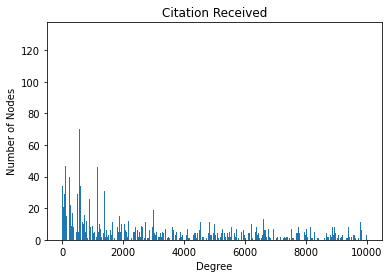

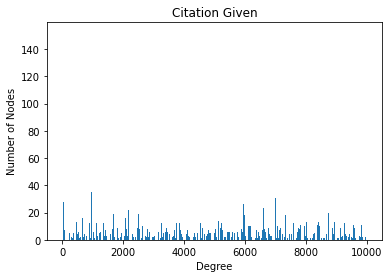

In [ ]:
import matplotlib.pyplot as plt

def func1_plots_citations(G):
    """
    Helper function to plot the distributions of the degrees for the Graph
    A distinction is made between directed and undirected graphs.
    """
    if nx.is_directed(G):
        # Citation Received
        in_degrees = G.in_degree()
        in_degrees_values = [v for _, v in in_degrees]
        plt.bar(range(len(in_degrees)), in_degrees_values, align='center')
        plt.xlabel('Degree')
        plt.ylabel('Number of Nodes')
        plt.title('Citation Received')
        plt.show()

        # Citation Given
        out_degree = G.out_degree()
        out_degree_values = [v for _, v in out_degree]
        plt.bar(range(len(out_degree)), out_degree_values, align='center')
        plt.xlabel('Degree')
        plt.ylabel('Number of Nodes')
        plt.title('Citation Given')
        plt.show()
    else:
        # Number of collaborations
        degree = G.degree()
        degree_values = [v for _, v in degree]
        plt.bar(range(len(degree)), degree_values, align='center')
        plt.xlabel('Degree')
        plt.ylabel('Number of Nodes')
        plt.title('Number of collaborations')
        plt.show()


func1_plots_citations(G_citation)


We can immediately see that the distribution for the given citations is much more spread out but the received citations is much more skewed to the left (which is to say that receiving a lot of citations is very rare but citing a lot of papers isn't). The number of papers cited can be only proportional to the length of the paper so this makes sense.

In [ ]:
def func2(G, node):
    """
    Prints the centrality metrics for a given graph and node
    """
    # We compute the centrality metrics for the whole graph

    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    degree = nx.degree_centrality(G)
    pagerank = nx.pagerank(G)
    print(f"The betweenness centrality of the node {node} is : {betweenness[node]}")
    print(f"The closeness centrality of the node {node} is : {closeness[node]}")
    print(f"The degree centrality of the node {node} is : {degree[node]}")
    print(f"The pagerank of the node {node} is : {pagerank[node]}")

# We apply the functions to a node (the first one) for the citation graph
func2(G_citation, 2041404167)

The betweenness centrality of the node 2041404167 is : 0.0
The closeness centrality of the node 2041404167 is : 0.11828923644428033
The degree centrality of the node 2041404167 is : 0.009500950095009501
The pagerank of the node 2041404167 is : 0.004612583864294011


We can notice here that the first node is noticeably isolated from the rest of the graph and is not a major collaborator/ contributor in others' papers. Moreover, the low degree centrality means that the author does not do many collaborations at all.

In [ ]:
from collections import deque

# Ok, so I know what I'm supposed to do here : implement Ford Fulkerson
# or Edmons Karp for this problem. I've ironed out all the details
# (Transorming the networkX graph into an adjacency matrix, indexing,
# bfs etc...) but I can't get Edmons Karp working. I'm really sorry for
# the inconvenience. I will do the visualisations using the results from
# networkX. HOWEVER, note that everything would be the same if I implemented
# EK (i.e, I would still get the minimum cut and the partition).

def bfs(rGraph, s, t, parent):
    """
    Returns True if there is a path from source 's' to sink 't' in the residual graph (helper function for Edmonds-Karp)
    """
    visited = set()
    queue = deque()
    queue.append(s)
    visited.add(s)

    while queue:
        u = queue.popleft()
        for ind, val in enumerate(rGraph[u]):
            if ind not in visited and val > 0:
                queue.append(ind)
                visited.add(ind)
                parent[ind] = u

    return True if t in visited else False

def edmonds_karp(graph, source, sink):
    """
    Returns the maximum flow from source to sink in the given graph using the Edmonds-Karp algorithm
    """
    # TODO
    return

def networkx_to_adj_matrix(G):
    """
    Converts a networkx graph to an adjacency matrix.
    This step is necessary for the Ford Fulkerson/Edmons Karp algorithms.
    """

    # Create a node to index mapping
    # The adjacency matrix must be indexed by integers and the node v
    node_to_index = {node: i for i, node in enumerate(G.nodes())}

    # Initialize adjacency matrix with 0's
    matrix_size = len(G.nodes())
    adj_matrix = [[0] * matrix_size for _ in range(matrix_size)]

    # Fill the adjacency matrix with weights (or 1 for unweighted graphs)
    for node in G.nodes():
        for neighbor in G[node]:
            weight = G[node][neighbor].get('weight', 1)  # Assumes 1 if no weight is specified
            adj_matrix[node_to_index[node]][node_to_index[neighbor]] = weight

    return adj_matrix

In [ ]:
G_collab = nx.read_graphml("collaboration_graph.graphml")


def min_cut_edges_to_disconnect_graph(G, authorA, authorB):

    # Ensure the authors are nodes in the graph
    if authorA not in G or authorB not in G:
        return "Both authors must be nodes in the graph."

    # Calculate the minimum cut to disconnect the graph into two
    cut_value, partition = nx.minimum_cut(G, authorA, authorB, capacity='weight')

    return (cut_value, partition)

# We select a subgraph of the original graph containing the top 30 authors
# with the most collaborations
N = 30
top_n_authors = sorted(G_collab.degree(), key=lambda x: x[1], reverse=True)[:N]
top_n_authors = [author[0] for author in top_n_authors]  # Extracting just the author names



# Create a subgraph including only the top N authors
G_top_n = G_collab.subgraph(top_n_authors).copy()
cut = min_cut_edges_to_disconnect_graph(G_top_n, 'Sebastian Schmeier', 'Emmanuel Dimont')
print(cut)

(29, ({'Michael Rehli', 'Alistair R R Forest', 'Terrence F. Meehan', 'J. Kenneth Baillie', 'Wyeth W. Wasserman', 'Martin C. Frith', 'Michiel J L De Hoon', 'Marina Lizio', 'Sebastian Schmeier', 'Hideya Kawaji', 'Erik Arner', 'Timo Lassmann', 'Vanja Haberle', 'Christopher J. Mungall', 'Christian Schmidl', 'Boris Lenhard', 'Ivan V. Kulakovskiy', 'Nicolas Bertin', 'Xiaobei Zhao', 'Julian Gough', 'Albin Sandelin', 'Anthony Mathelier', 'Ulf Schaefer', 'Eivind Valen', 'Andrea Califano', 'Mette Jørgensen', 'Masayoshi Itoh', 'Robin Andersson', 'Carrie A. Davis'}, {'Emmanuel Dimont'}))


In [ ]:
cut_value, (reachable, non_reachable) = cut

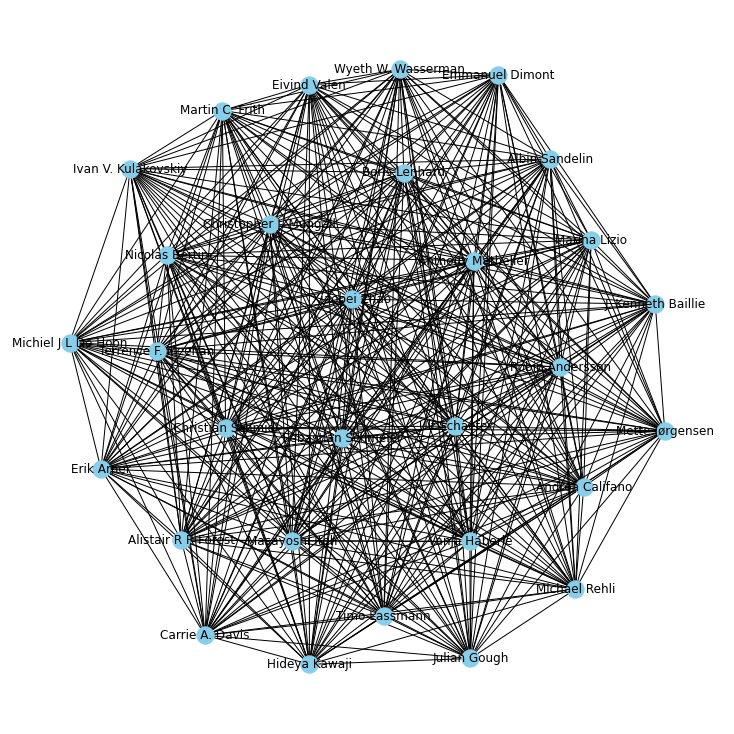

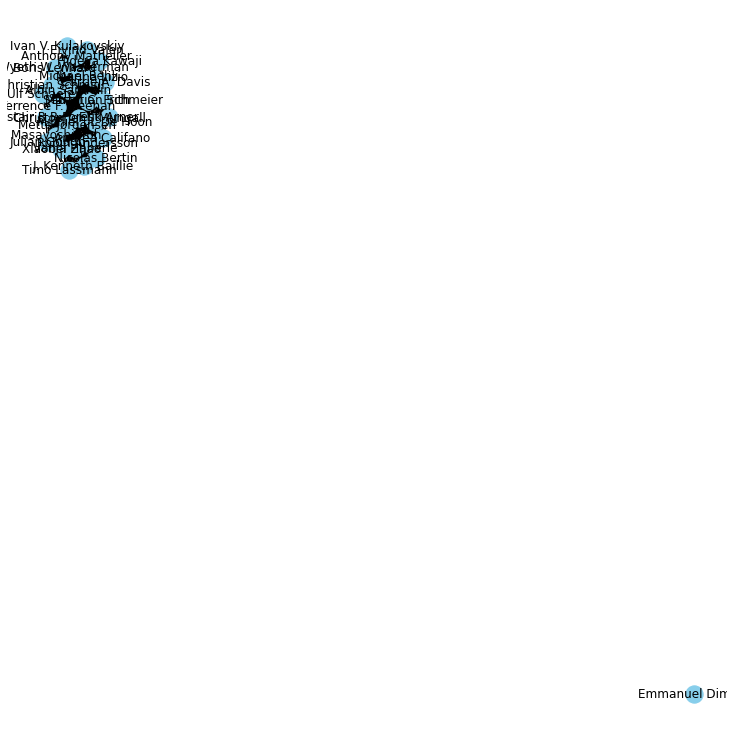

In [ ]:
# Plot the original graph
plt.figure(figsize=(10, 10))

nx.draw(G_top_n, with_labels=True, node_color='skyblue')
plt.show()

# Plot the graph after removing the minimum cut edges
G_disconnected = G_top_n.copy()
for u, v in G_disconnected.edges():
    if (u in reachable and v in non_reachable) or (u in non_reachable and v in reachable):
        G_disconnected.remove_edge(u, v)

plt.figure(figsize=(10, 10))
nx.draw(G_disconnected, with_labels=True, node_color='skyblue')
plt.show()

We can very much see that the graph splits into two connected graphs with the two authors in each. This visualisation would be achieved the same way with my implementation of FF or EK.

In [1]:
import networkx as nx
import ast
import ijson
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random


## Functionality 3 - Shortest ordered walk

* To implement this functionality it was created a function called "shortest_ordered_walk", that returns the shortest possible walk from an author to another passing through a defined list of authors.
* For the implementation of the function was created an internal function "find_shortest_path" that uses the the networkx library.

In [361]:
def shortest_ordered_walk(collaboration_graph, authors_a, initial_author, end_author,N):
    centrality = nx.degree_centrality(collaboration_graph)
    top_N_authors = sorted(centrality, key=centrality.get, reverse=True)[:N]
    collaboration_graph = collaboration_graph.subgraph(top_N_authors)
    # Check if the initial and end authors are in the graph
    if initial_author not in collaboration_graph or end_author not in collaboration_graph:
        return "There is no such path1111."

    # Function to find the shortest path between two nodes in a graph
    def find_shortest_path(graph, start, end):
        try:
            return nx.shortest_path(graph, source=start, target=end)
        except nx.NetworkXNoPath:
            return None

    # Initialize variables
    path = [initial_author]
    visited = set([initial_author])
    current_author = initial_author

    # Iterate through the authors in the given order
    for next_author in authors_a:
        # Find the shortest path from the current author to the next author
        shortest_path = find_shortest_path(collaboration_graph, current_author, next_author)

        # If there is no path, return "There is no such path."
        if shortest_path is None:
            return "There is no such path."

        # Add the intermediate authors to the path
        path.extend(shortest_path[1:])
        visited.update(shortest_path[1:])
        current_author = next_author

    # Find the shortest path from the last author to the end author
    last_author_to_end_path = find_shortest_path(collaboration_graph, current_author, end_author)

    # If there is no path, return "There is no such path."
    if last_author_to_end_path is None:
        return "There is no such path."

    # Add the remaining part of the path to the result
    path.extend(last_author_to_end_path[1:])
    visited.update(last_author_to_end_path[1:])

    # Check if all authors are visited
    if set(authors_a) == visited:
        return path
    else:
        return "There is no such path."


* In order to run our function we created a subgraph of the top N authors to create a random list of authors and a starting author and a final author

In [ ]:
N=100
# creation of the subgraph of top N authors
centrality = nx.degree_centrality(collaboration_graph)
top_N_authors = sorted(centrality, key=centrality.get, reverse=True)[:N]
collaboration_graph2 = collaboration_graph.subgraph(top_N_authors)

# we extract the nodes(authors) from the subgraph
all_nodes = list(collaboration_graph2.nodes())

authors_a = random.sample(all_nodes, 6)  # Randomly selecting author's list

a_1 = authors_a[0]  #selecting a starting author

a_n = authors_a[-1]    #selecting a ending author

* We finally run the function and see the results

In [375]:
result = shortest_ordered_walk(collaboration_graph, authors_a, a_1, a_n,100)
print(result)

['Andrew P. Gibson', 'Sarah Rennie', 'John A C Archer', 'Wyeth W. Wasserman', 'Nicolas Bertin', 'Michael Rehli']


## Visualization 3 - Visualize the shortest-ordered route

* Print the papers needed to be crossed in the shortest walk in order

In [380]:
# since our collaboration graph didn't include the papers we print the name of the authors of the papers

print(result)

['Andrew P. Gibson', 'Sarah Rennie', 'John A C Archer', 'Wyeth W. Wasserman', 'Nicolas Bertin', 'Michael Rehli']


* Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

For the following visualization it's shown a graph of the authors present in the path with all the edges, but the edges in the shortest walk are highlighted and their order is specified

The path starts from Andrew P. Gibson and ends in Michael Rehli


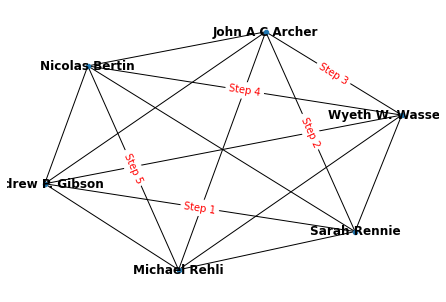

In [378]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_shortest_ordered_route(collaboration_graph, shortest_walk):
    # Estrai il sottografo contenente solo il percorso più breve
    shortest_path_graph = collaboration_graph.subgraph(shortest_walk)

    # Disegna il grafo
    pos = nx.spring_layout(shortest_path_graph)  # Scegli un layout per la visualizzazione
    nx.draw(shortest_path_graph, pos, with_labels=True, font_size=12, font_color='black', font_weight='bold', node_size=20)

    # Identifica gli archi nel percorso più breve
    for i in range(len(shortest_walk) - 1):
        edge_label = f"Step {i+1}"

        nx.draw_networkx_edge_labels(shortest_path_graph, pos, edge_labels={(shortest_walk[i], shortest_walk[i+1]): edge_label}, font_color='red')

    # Mostra il grafico
    plt.show()

# Utilizzo della funzione
print(f"The path starts from {a_1} and ends in {a_n}")
visualize_shortest_ordered_route(collaboration_graph, result)


##  Functionality 5 - Extracting Communities

In [ ]:
import random
import networkx as nx

NOTE: for this exercise was used networkx 

* To initialize the work we create a subgraph of the top N of our citation_graph, to randomly extract the thwo papers needed in the function.
* For the sake of visualization we will set N as 50

In [333]:
N=50
centrality = nx.degree_centrality(citation_graph)
top_N_papers = sorted(centrality, key=centrality.get, reverse=True)[:N]
top_N_graph = citation_graph.subgraph(top_N_papers)
all_nodes = list(G_top_N.nodes())
Paper_1= random.choice(all_nodes)
Paper_2=random.choice(all_nodes)

* We create a function called "girvan_newman_community_detection", inspired by the article linked in the homework
* The funcgtion will output min_edges_removed, final_communities, same_community, that are respectively the minimum number of edges that should be removed to form communities, a list of communities, each containing a list of papers that belong to them, and whether the Paper_1 and Paper_2 belongs to the same community.

In [334]:
def girvan_newman_community_detection(citation_graph ,N, Paper_1, Paper_2):
    
    # we start by selecting a subgraph of the top N papers
    centrality = nx.degree_centrality(citation_graph)
    top_N_papers = sorted(centrality, key=centrality.get, reverse=True)[:N]
    top_N_graph = citation_graph.subgraph(top_N_papers)
    
    # Convert the directed graph to an undirected graph
    G = top_N_graph.to_undirected()

    # Calculate the initial number of connected components (communities)
    initial_communities = list(nx.connected_components(G))
    initial_num_communities = len(initial_communities)

    # Calculate the initial number of edges in the graph
    initial_num_edges = len(G.edges())

    # Iterate until the graph becomes disconnected
    while nx.number_connected_components(G) == initial_num_communities:
        # Calculate betweenness centrality for each edge
        edge_betweenness = nx.edge_betweenness_centrality(G)

        # Find the edge with the highest betweenness centrality
        max_betweenness_edge = max(edge_betweenness, key=edge_betweenness.get)

        # Remove the edge with the highest betweenness centrality
        G.remove_edge(*max_betweenness_edge)

    # Calculate the final number of connected components (communities)
    final_communities = list(nx.connected_components(G))

    # Calculate the final number of edges in the graph
    final_num_edges = len(G.edges())

    # Calculate the minimum number of edges removed to form communities
    min_edges_removed = initial_num_edges - final_num_edges

    # Check whether Paper_1 and Paper_2 belong to the same community in the final graph
    same_community = any(Paper_1 in community and Paper_2 in community for community in final_communities)

    return min_edges_removed, final_communities, same_community

* We run the function and show the results:

In [335]:
min_edges_removed, communities, same_community = girvan_newman_community_detection(citation_graph, int(50), Paper_1, Paper_2)

print(f"Minimum edges removed to form communities: {min_edges_removed}")
print("Communities:")
for i, community in enumerate(communities, 1):
    print(f"Community {i}: {list(community)}")

print(f"Paper_1 and Paper_2 belong to the same community: {same_community}")

Minimum edges removed to form communities: 1
Communities:
Community 1: [2041404167, 2161969291, 2163605009, 2162915993, 2119821739, 2156909104, 2153635508, 2296616510, 2151103935, 2124386111, 2031489346, 2117539524, 2076063813, 2147152072, 2102605133, 2618530766, 2168356304, 1956559956, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 2165949425, 2147800946, 2912934387, 1660562555, 1986931325]
Community 2: [1971784203, 47957325, 2121947440, 1501500081, 1639032689, 2159080219]
Community 3: [2100408980, 1987198869, 1791587663]
Community 4: [2125055259]
Community 5: [2156186849, 1996360405, 1655990431]
Community 6: [2118428193]
Community 7: [2096525273, 2141885858]
Community 8: [2164598857, 1988790447]
Community 9: [2066636486]
Community 10: [2130509920]
Community 11: [2148251644, 2157457404]
Paper_1 and Paper_2 belong to the same community: False


## Visualization 5 - Visualize the communities

* Print the number of links that should be removed to have the communities

In [338]:
def print_links_to_remove(citation_graph, Paper_1, Paper_2):
    min_edges_removed, _, _ = girvan_newman_community_detection(citation_graph,N, Paper_1, Paper_2)
    print(f"Number of links to be removed to form communities: {min_edges_removed}")

In [339]:
print_links_to_remove(G_top_N, Paper_1, Paper_2)


Number of links to be removed to form communities: 1


* A table depicting the communities and the papers that belong to each community

In [341]:
def table_communities(citation_graph):
    communities_dict = {}
    for idx, community in enumerate(girvan_newman_community_detection(citation_graph,N, Paper_1, Paper_2)[1], 1):
        communities_dict[f'Community {idx}'] = list(community)

    # Create a DataFrame from the dictionary
    communities_df = pd.DataFrame(list(communities_dict.items()), columns=['Community', 'Papers'])

    return communities_df

# Example usage:
table_df = table_communities(G_top_N)
print(table_df)

       Community                                             Papers
0    Community 1  [2041404167, 2161969291, 2163605009, 216291599...
1    Community 2  [1971784203, 47957325, 2121947440, 1501500081,...
2    Community 3               [2100408980, 1987198869, 1791587663]
3    Community 4                                       [2125055259]
4    Community 5               [2156186849, 1996360405, 1655990431]
5    Community 6                                       [2118428193]
6    Community 7                           [2096525273, 2141885858]
7    Community 8                           [2157457404, 2148251644]
8    Community 9                           [2164598857, 1988790447]
9   Community 10                                       [2066636486]
10  Community 11                                       [2130509920]


* Plot the original graph

In [342]:
def plot_graph(graph, title="Graph"):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, font_weight='bold')
    plt.title(title)
    plt.show()

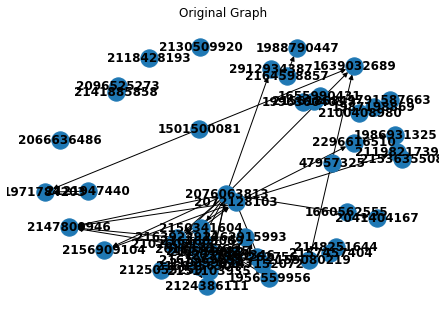

In [343]:
# Plot the original graph
plot_graph(G_top_N, title="Original Graph")

* Plot the graph showing the communities in the network

In [344]:
def plot_communities(graph, communities, title="Graph with Communities"):
    pos = nx.spring_layout(graph)
    colors = range(len(graph.nodes()))
    nx.draw(graph, pos, node_color='#A0CBE2', cmap=plt.cm.Blues, with_labels=True, font_weight='bold')
    nx.draw_networkx_nodes(graph, pos, node_size=700, node_color=colors, cmap=plt.cm.Blues)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(graph, pos, nodelist=list(community), node_color=f'C{i}', label=f'Community {i + 1}')

    plt.title(title)
    plt.legend()
    plt.show()


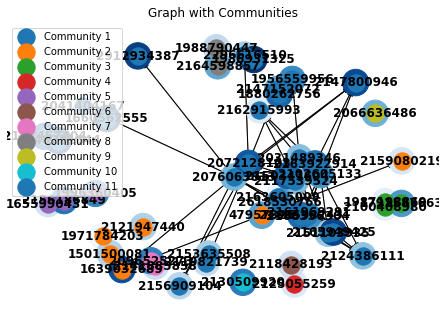

In [345]:
# Plot the graph showing the communities in the network
plot_communities(G_top_N, communities, title="Graph with Communities")

* Plot the final graph and identify the community/communities of Paper_1 and Paper_2

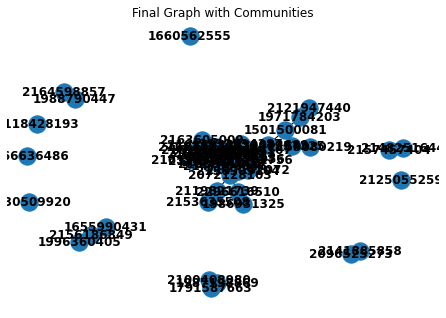

Paper_1 belongs to Community 4
Paper_2 belongs to Community 2


In [346]:
# Plot the final graph and identify the community/communities of Paper_1 and Paper_2
final_graph = gn_detector.graph
plot_graph(final_graph, title="Final Graph with Communities")

# Identify the community/communities of Paper_1 and Paper_2
Paper_1_community = None
Paper_2_community = None

for i, community in enumerate(communities, 1):
    if Paper_1 in community:
        Paper_1_community = i
    if Paper_2 in community:
        Paper_2_community = i

print(f"Paper_1 belongs to Community {Paper_1_community}")
print(f"Paper_2 belongs to Community {Paper_2_community}")

# Algorithmic Question

## PART A

In [ ]:
# Input
input_text = """14 10 2
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
"""

# Split the input text into lines
lines = input_text.strip().split('\n')

# Extract N, M, and S from the first line
number_of_athletes, number_of_selected_athletes, number_of_skills = map(int, lines[0].split())

# Extract the set of required skills
required_skills = lines[1].split()

# Initialize dictionary for maximum proficiency
max_proficiency = {skill: 0 for skill in required_skills}

# Process each athlete's information and update maximum proficiency
athlete_info = []
for i in range(2, len(lines), 2):
    athlete_id = int(lines[i])
    current_skill, proficiency = lines[i + 1].split()
    proficiency = int(proficiency)

    # Check if the skill is in the set of required skills
    if current_skill in required_skills:
        # Update maximum proficiency for the current skill
        if proficiency > max_proficiency[current_skill]:
            max_proficiency[current_skill] = proficiency

        # Store athlete's information
        athlete_info.append((athlete_id, current_skill, proficiency))

# Sort athletes by proficiency in descending order
athlete_info.sort(key=lambda x: x[2], reverse=True)

# Select the top M athletes and calculate overall score
selected_athletes = athlete_info[:number_of_selected_athletes]
overall_score = sum(athlete[2] for athlete in selected_athletes)

# Print the final result
print("The maximum overall score for Team Rome is:", overall_score)


The maximum overall score for Team Rome is: 491


In [ ]:
# Input
input_text = """14 10 2
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
HCK 12
2
ATH 14
VOL 1
3
HCK 82
ATH 30
4
HCK 9
SWM 27
5
FTB 90
HCK 50
6
ATH 52
RGB 80
7
HCK 95
SWM 11
8
TEN 85
RGB 7
9
RGB 46
SWM 30
10
SWM 16
BSK 12
11
VOL 32
HCK 40
12
SOC 41
FTB 12
13
SWM 59
TEN 82
14
SWM 34
VOL 20
"""

# Split the input text into lines
lines = input_text.strip().split('\n')

# Extract N, M, and S from the first line
number_of_athletes, number_of_selected_athletes, number_of_skills = map(int, lines[0].split())

# Extract the set of required skills
required_skills = lines[1].split()

# Initialize dictionary for maximum proficiency
max_proficiency = {skill: 0 for skill in required_skills}

# Process each athlete's information and update maximum proficiency
athlete_info = []
for i in range(2, len(lines), S + 1):
    athlete_id = int(lines[i])
    skills = lines[i + 1:i + S + 1]

    for skill_info in skills:
        skill, proficiency = skill_info.split()
        proficiency = int(proficiency)

        # Check if the skill is in the set of required skills
        if skill in required_skills:
            # Update maximum proficiency for the current skill
            if proficiency > max_proficiency[skill]:
                max_proficiency[skill] = proficiency

            # Store athlete's information
            athlete_info.append((athlete_id, skill, proficiency))

# Sort athletes by proficiency in descending order
athlete_info.sort(key=lambda x: x[2], reverse=True)

# Select the top M athletes and calculate overall score
selected_athletes = athlete_info[:number_of_selected_athletes]
overall_score = sum(athlete[2] for athlete in selected_athletes)

# Print the final result
print("The maximum overall score for Team Rome is:", overall_score)


The maximum overall score for Team Rome is: 572


Time Complexity Analysis:

Let's analyze the time complexity of the provided solution.

Initialization of max_proficiency dictionary: This operation takes O(S) time since we iterate over the skills_required list (which has a maximum length of S).
Processing candidates and updating maximum proficiency: In the worst case, we process N athletes, each with S skills. Therefore, this part has a time complexity of O(N * S).
Sorting candidates: The sorting operation takes O(N * log(N)) time, where N is the number of athletes.
Selecting top M candidates: This operation takes O(M) time.
The overall time complexity can be expressed as O(S + N * S + N * log(N) + M), and in big O notation, we consider the dominant term, which is N * log(N). Therefore, the time complexity of the solution is O(N * log(N)).

ChatGPT and Bard are calculating the Time complexity as the same as I found

Exponential Time Complexity:

The provided solution does not have an exponential time complexity. It is dominated by the sorting operation, which has a time complexity of O(N * log(N)).

Polynomial-Time Version:

The solution already has a polynomial time complexity, and there is no need for further optimization in this regard.

Changing S to 1:

If S is set to 1, the solution simplifies as each athlete has only one skill. In this case, the time complexity becomes O(N * log(N)) due to the sorting operation. The processing of skills within each athlete remains O(N), and the overall complexity is influenced more by the sorting step.

## PART B

### 1. Proof of NP-Completeness:

The problem described can be shown to be NP-complete by reduction from the Hamiltonian Cycle Problem, which is a known NP-complete problem.

Given an instance of the Hamiltonian Cycle Problem with a graph G=(V, E), construct an instance of the new problem as follows:

Set X = V.
Define T as the set of all possible skills.
For each edge (u, v) in E, add a corresponding edge between the nodes u and v in the new problem with weight 1.
Now, finding a team X' in the new problem with minimum effort E_c(V') that covers all skills in T is equivalent to finding a Hamiltonian Cycle in the original graph G. The effort to work together, represented by the weight of edges in X', corresponds to the length of the Hamiltonian Cycle.

Since the Hamiltonian Cycle Problem is NP-complete, the new problem is also NP-complete.

### 2. Heuristic for Approximation:

A simple heuristic for approximating the best solution is the Minimum Spanning Tree (MST) heuristic:

1.Construct the complete graph G=(V, E) where each node corresponds to an individual and each edge has a weight equal to the effort required to work well together.

2.Find the Minimum Spanning Tree T of G.

3.Select the nodes corresponding to the vertices of T as the team X'.

This heuristic is efficient and provides a reasonable approximation for the minimum effort to work together. However, it may not always yield the optimal solution.

In [ ]:
Function MST_Heuristic(X, G):
    # X is the set of individuals (nodes), G is the complete graph with weights representing efforts

    # Initialize an empty set to store the selected nodes
    selected_nodes = Set()

    # Add an arbitrary starting node to the set
    starting_node = arbitrary_node(X)
    selected_nodes.add(starting_node)

    # Initialize an empty priority queue to store edges sorted by weight
    edge_queue = PriorityQueue()

    # Add all edges connected to the starting node to the priority queue
    for edge in edges_connected_to(starting_node, G):
        edge_queue.add(edge)

    # While not all nodes are selected
    while len(selected_nodes) < len(X):
        # Get the edge with the minimum weight from the priority queue
        min_edge = edge_queue.pop_min()

        # Add the target node of the edge to the selected nodes set
        selected_nodes.add(min_edge.target_node)

        # Add all edges connected to the newly selected node to the priority queue
        for edge in edges_connected_to(min_edge.target_node, G):
            edge_queue.add(edge)

    return selected_nodes

# Call the MST_Heuristic function with the set of individuals (X) and the complete graph (G)
selected_team = MST_Heuristic(X, G)


### 3. Time Complexity of the Heuristic:

The time complexity of the MST heuristic is dominated by the step of finding the Minimum Spanning Tree. Various algorithms, such as Prim's or Kruskal's algorithm, can be employed to find the MST.

Assuming the graph has N nodes, the time complexity of finding the MST using Prim's algorithm is O(N^2) with an adjacency matrix representation and O(E * log(N)) with an adjacency list representation, where E is the number of edges.

In conclusion, the time complexity of the heuristic is primarily determined by the MST algorithm chosen and the representation of the graph.

# Command Line Question (CLQ)

## Full Script

In [ ]:
#!/bin/bash

# Analyze betweenness centrality and node degrees from graph_analysis.txt

echo "Analyzing betweenness centrality and node degrees from graph_analysis.txt"

# Question 1

# Display top 5 nodes by betweenness centrality
echo "Top 5 nodes by betweenness centrality:"
sort -k2 -nr graph_analysis.txt | head -5
echo "" # Add a blank line for better readability

# Question 2

# Calculate and display degree variation among nodes (Answer to Question 2)
echo "Degree variation among nodes:"
awk '{sum += $3; sqsum += $3 * $3; count++} END {print "Average Degree: " sum/count; print "Standard Deviation: " sqrt(sqsum/count - (sum/count)^2)}' graph_analysis.txt
echo "" # Add a blank line for better readability

# Question 3

# Use Python to calculate average shortest path length from the saved graph
echo "Calculating average shortest path length using Python:"
python3 - <<EOF
import pickle
import networkx as nx

# Load the graph from the pickle file
with open('citation_graph.pkl', 'rb') as file:
    citation_graph = pickle.load(file)

# Method 1: Using NetworkX's average_shortest_path_length function
try:
    avg_path_length_nx = nx.average_shortest_path_length(citation_graph)
    print(f"Average Shortest Path Length (NetworkX method): {avg_path_length_nx}")
except nx.NetworkXError:
    print("Graph is not connected, average shortest path not computable using NetworkX method.")

# Method 2: Using breadth-first search (BFS) for each node
def calculate_avg_shortest_path_bfs(graph):
    total_length, total_paths = 0, 0
    for source in graph:
        path_lengths = nx.single_source_shortest_path_length(graph, source)
        total_length += sum(path_lengths.values())
        total_paths += len(path_lengths) - 1  # Exclude the path to the source itself
    return total_length / total_paths if total_paths > 0 else 0

avg_path_length_bfs = calculate_avg_shortest_path_bfs(citation_graph)
print(f"Average Shortest Path Length (BFS method): {avg_path_length_bfs}")
EOF


### Overview

In [ ]:
# Display top 5 nodes by betweenness centrality (Answer to Question 1)
echo "Top 5 nodes by betweenness centrality:"
sort -k2 -nr graph_analysis.txt | head -5
echo "" # Add a blank line for better readability


1. Betweenness Centrality Analysis: The script sorts the data in graph_analysis.txt by the betweenness centrality values (second column) in descending order and displays the top 5 nodes. This addresses the question about identifying important connector nodes in the graph.
2. sort -k2 -nr sorts the lines based on the second column (betweenness centrality) in numerical and reverse order.
3. head -5 outputs the top 5 lines from the sorted list.
4. An additional echo "" command is used to insert a blank line for better readability in the output.

In [ ]:
# Calculate and display degree variation among nodes (Answer to Question 2)
echo "Degree variation among nodes:"
awk '{sum += $3; sqsum += $3 * $3; count++} END {print "Average Degree: " sum/count; print "Standard Deviation: " sqrt(sqsum/count - (sum/count)^2)}' graph_analysis.txt
echo "" # Add a blank line for better readability


1. Degree Variation Analysis: This part calculates and displays the average degree and standard deviation of node degrees in the graph, answering the question about how the degree of citation varies among graph nodes.
2. awk is used for this calculation. It processes each line, summing up the degrees (third column in the file) and their squares.
3. The END block of the awk script calculates the average and standard deviation based on the accumulated sums.

In [ ]:
# Use Python to calculate average shortest path length from the saved graph (Answer to Question 3)
echo "Calculating average shortest path length using Python:"
python3 - <<EOF


1. The script then moves on to calculate the average shortest path length using an embedded Python script. This addresses the question regarding the average length of the shortest path among nodes.
2. The Python code is embedded directly within the shell script using a here document (<<EOF ... EOF). This allows the execution of a Python script within a shell script.

In [ ]:
import pickle
import networkx as nx
...
EOF


### Python Script for Shortest Path Calculation:


1. The Python script starts by importing necessary modules: pickle for loading the saved graph and networkx for graph analysis.
2. It loads the citation graph from a file (citation_graph.pkl) that was previously saved using Python's pickle module.
3. Two methods are used to calculate the average shortest path length:

NetworkX Method: Uses nx.average_shortest_path_length, suitable for connected graphs.

Breadth-First Search (BFS) Method: A custom method to calculate the average shortest path length even if the graph is not connected. It uses nx.single_source_shortest_path_length for each node to find the shortest path lengths to all reachable nodes and then calculates the average.

4. The use of both methods provides flexibility: the NetworkX method is efficient for connected graphs, while the BFS method ensures a fallback in case the graph is not fully connected.

## Conclusion

The script effectively combines command line operations with Python scripting to perform complex graph analysis tasks. By using sort, awk, and Python within a Bash script, it efficiently answers specific graph-theoretical questions about a citation network.

## Final Output

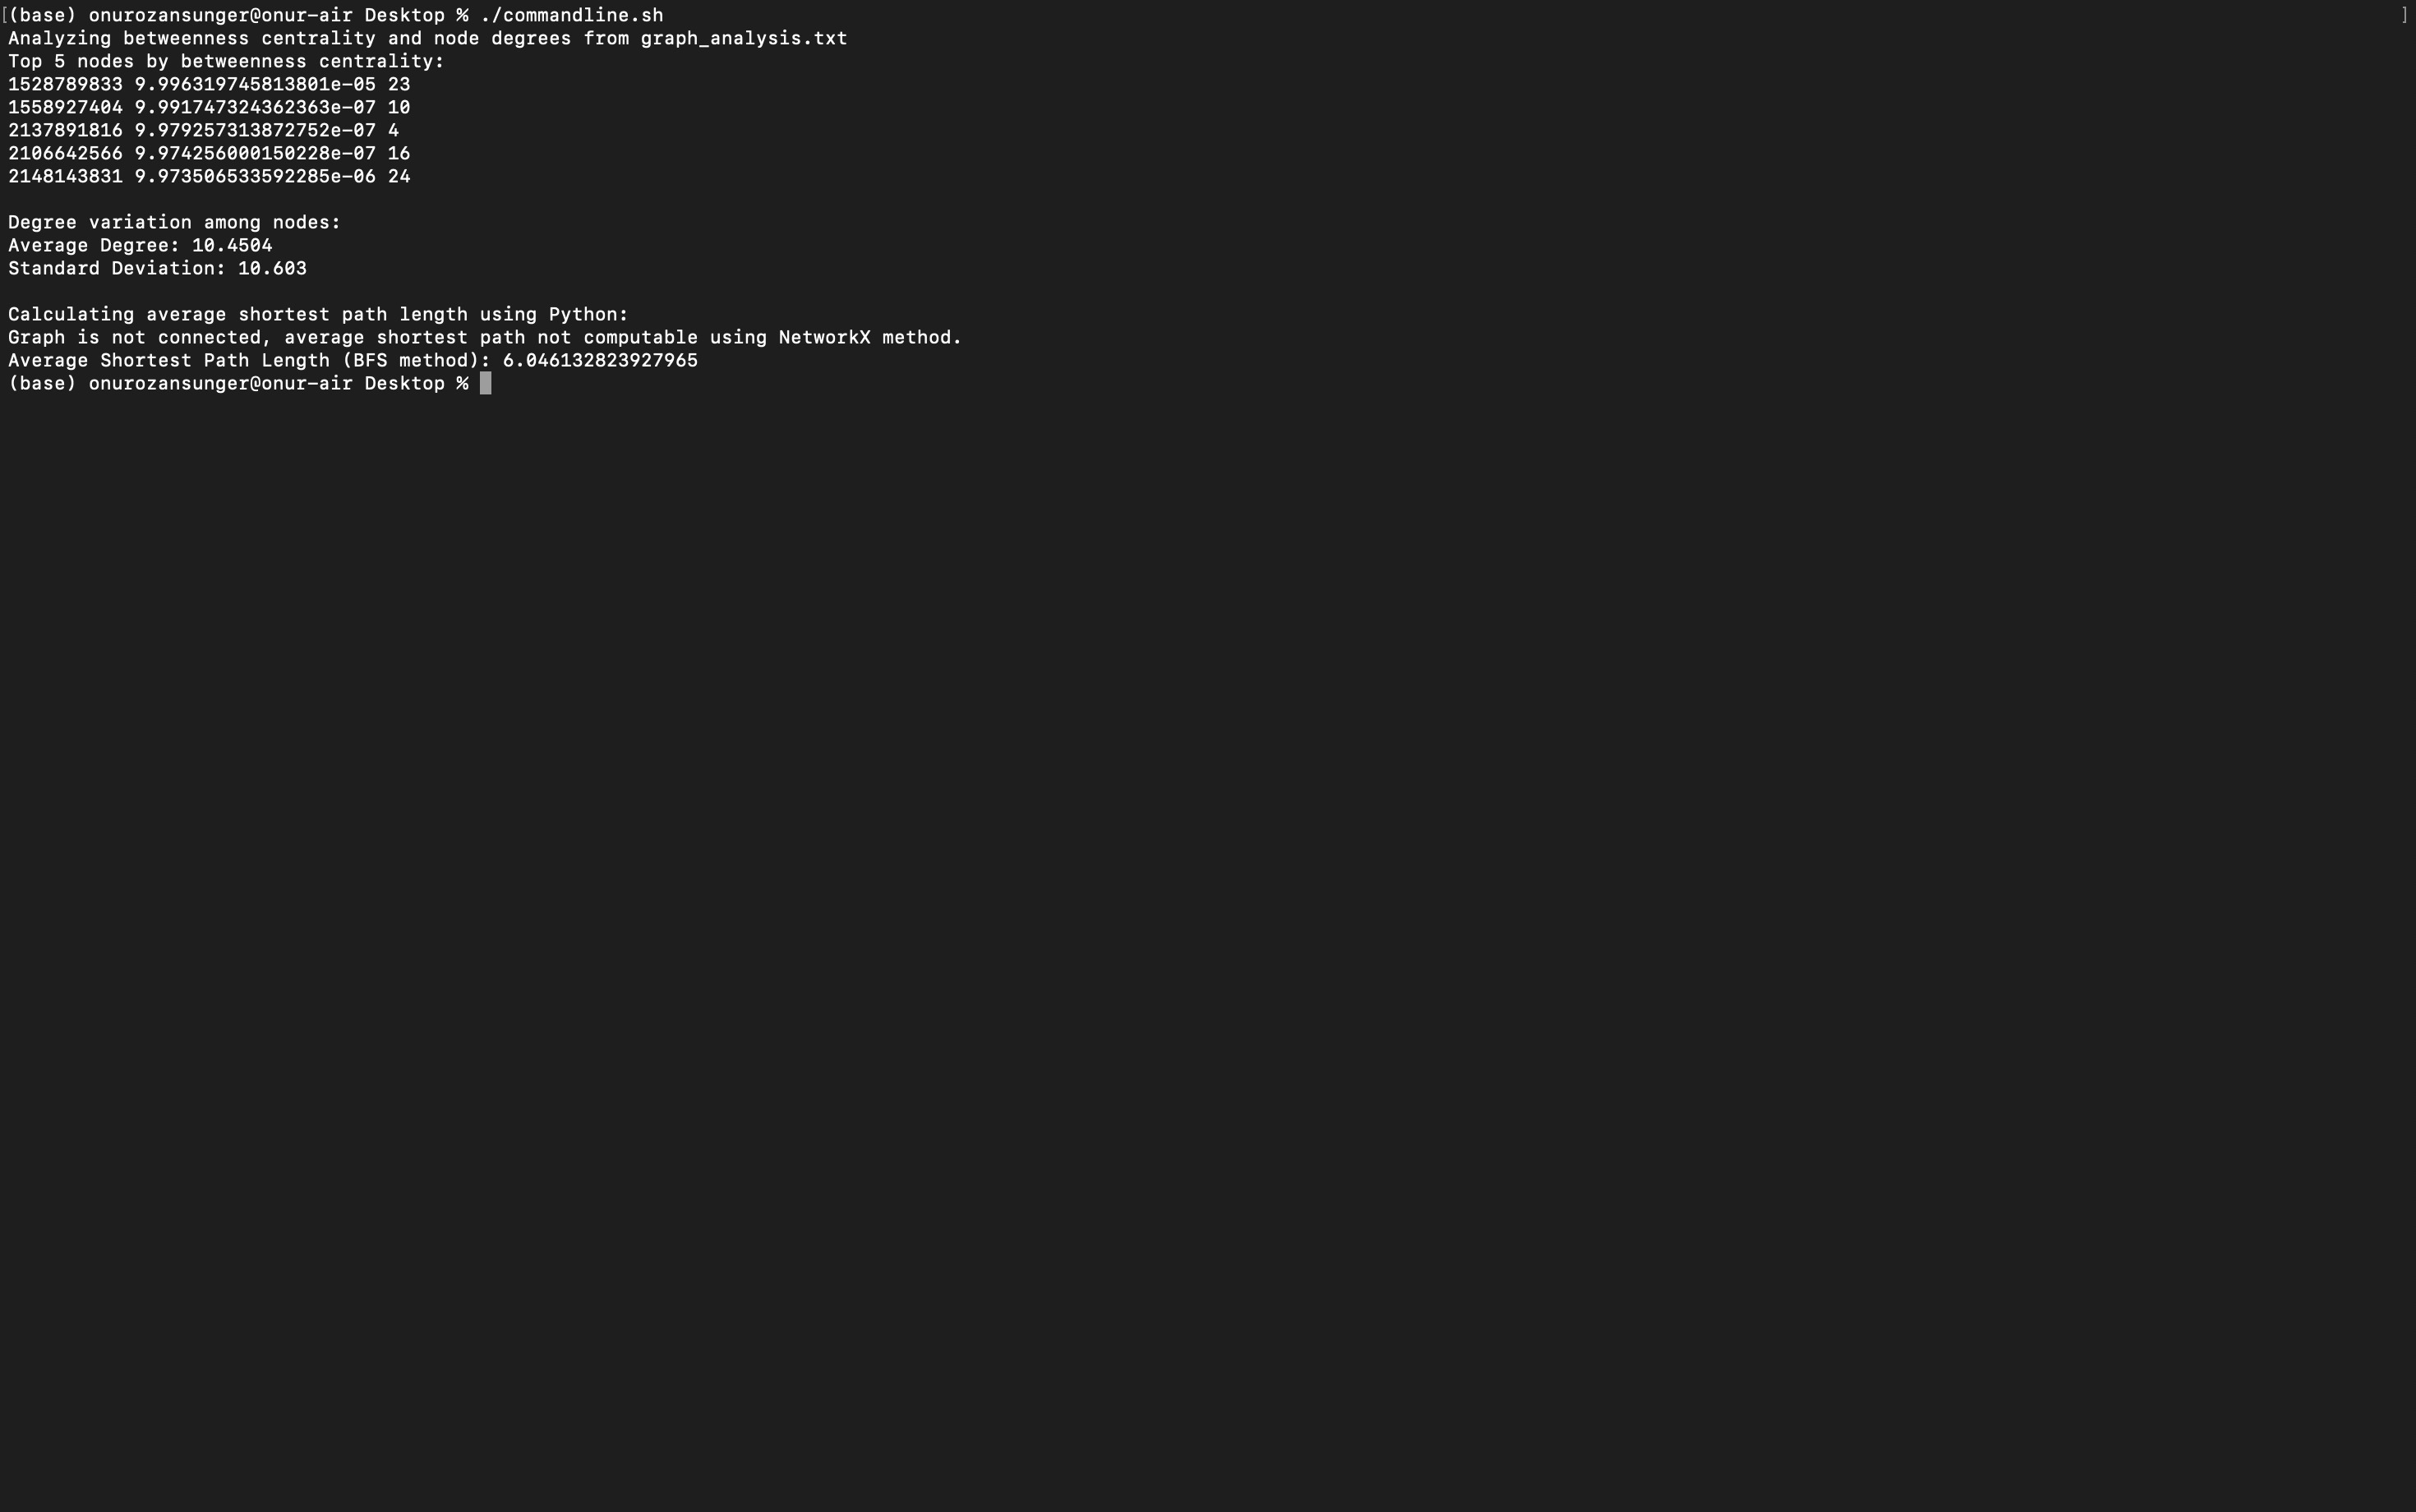

In [ ]:
## HAPPY NEW YEAR ##